# Prediksi Emosi Spotify - Pipeline Lengkap
Model: Logistic Regression pada fitur mentah  
Simpan: model, daftar fitur, dan metrik evaluasi

## 1. Import Library

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score
)

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

## 2. Load Dataset

In [36]:
# Muat data
df = pd.read_csv('Spotify Song Attributes.csv')

# Hapus kolom tidak relevan
df = df.drop(columns=['id', 'Unnamed: 0', 'song_title', 'artist'], errors='ignore')

# Hapus baris tanpa valence
df = df.dropna(subset=['valence'])

# Buat target biner: valence > 0.5 → 1 (Positif), else 0
df['target'] = (df['valence'] > 0.5).astype(int)

# Pastikan tipe data konsisten dengan dataset asli (float)
df['key'] = df['key'].astype(float)
df['time_signature'] = df['time_signature'].astype(float)

print(f"✅ Dataset dimuat. Jumlah baris: {len(df)}")

✅ Dataset dimuat. Jumlah baris: 2017


## 3. Rekayasa Fitur

In [37]:
# Pisahkan fitur dan target
X = df.drop(columns=['valence', 'target'])
y = df['target']

# One-hot encoding untuk variabel kategorikal
X = pd.get_dummies(
    X,
    columns=['key', 'time_signature'],
    prefix=['key', 'ts'],
    drop_first=True
)

# Tambahkan fitur interaksi
X['mode_x_energy'] = X['mode'] * X['energy']
X['mode_x_danceability'] = X['mode'] * X['danceability']
X['energy_x_acousticness'] = X['energy'] * X['acousticness']

# Simpan daftar fitur untuk alignment saat inferensi
feature_columns = X.columns.tolist()

print(f"✅ Rekayasa fitur selesai. Total fitur: {X.shape[1]}")

✅ Rekayasa fitur selesai. Total fitur: 27


## 4. Split Data

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"✅ Data dibagi:")
print(f"   - Train: {X_train.shape[0]} sampel")
print(f"   - Test:  {X_test.shape[0]} sampel")

✅ Data dibagi:
   - Train: 1613 sampel
   - Test:  404 sampel


## 5. Latih Model

In [39]:
# Setup hyperparameter tuning
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(
    LogisticRegression(max_iter=2000, random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Latih model
grid.fit(X_train, y_train)
best_model = grid.best_estimator_

print(f"✅ Model terlatih!")
print(f"   - Best C: {grid.best_params_['C']}")

✅ Model terlatih!
   - Best C: 100


## 6. Evaluasi

In [40]:
# Prediksi
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Metrik
acc = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_proba)

print(f"\n🎯 METRIK EVALUASI:")
print(f"   - Akurasi    : {acc:.4f}")
print(f"   - AUC        : {auc_score:.4f}")
print(f"\n📋 LAPORAN KLASIFIKASI:")
print(classification_report(y_test, y_pred, target_names=['Negatif/Netral', 'Positif']))


🎯 METRIK EVALUASI:
   - Akurasi    : 0.6832
   - AUC        : 0.7565

📋 LAPORAN KLASIFIKASI:
                precision    recall  f1-score   support

Negatif/Netral       0.70      0.67      0.68       207
       Positif       0.67      0.70      0.68       197

      accuracy                           0.68       404
     macro avg       0.68      0.68      0.68       404
  weighted avg       0.68      0.68      0.68       404



## 7. Visualisasi

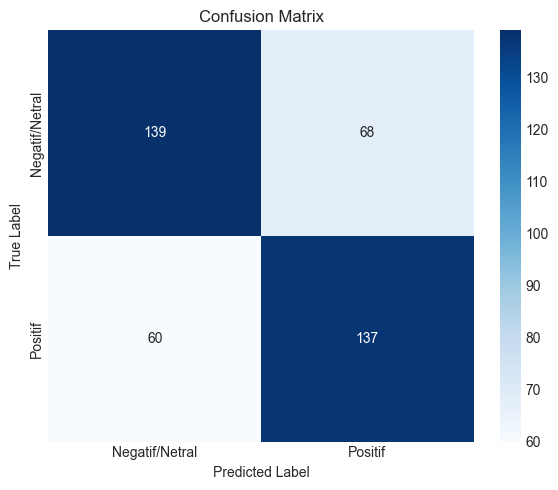

In [41]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Negatif/Netral', 'Positif'],
    yticklabels=['Negatif/Netral', 'Positif']
)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## 8. Simpan Model dan Artefak

In [42]:
# Simpan model
with open('logistic_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Simpan daftar fitur (WAJIB untuk prediksi baru)
with open('feature_columns.pkl', 'wb') as f:
    pickle.dump(feature_columns, f)

# Simpan metrik
with open('model_accuracy.txt', 'w') as f:
    f.write(f"Akurasi: {acc:.4f}\n")
    f.write(f"AUC: {auc_score:.4f}\n")
    f.write(f"Best C: {grid.best_params_['C']}\n")

print("\n✅ SEMUA ARTEFAK TELAH DISIMPAN:")
print("   - logistic_model.pkl      → Model terlatih")
print("   - feature_columns.pkl     → Daftar fitur")
print("   - model_accuracy.txt      → Metrik performa")


✅ SEMUA ARTEFAK TELAH DISIMPAN:
   - logistic_model.pkl      → Model terlatih
   - feature_columns.pkl     → Daftar fitur
   - model_accuracy.txt      → Metrik performa
